# Data Mining - What should the next Champion look like?

## Problemdefiniton
In League of Legends beeinflussen neue Champions die Spielbalance. Doch sind bestimmte Champion-Typen unterrepräsentiert? Diese Arbeit nutzt Machine Learning, um vorherzusagen, welche Champion-Eigenschaften im aktuellen Spielgewicht fehlen.

So wird sich die zentrale Frage gestellt: Welche Kombination von Champion-Eigenschaften ist im derzeitigen Spielökosystem am stärksten unterrepräsentiert und könnte als Grundlage für die Entwicklung eines neuen Champions dienen?

## Import - Datenauswahl

### Import notwendiger Bibliotheken


In [2]:
# Datenverarbeitung & Numerik
import pandas as pd  # Datenverarbeitung
import numpy as np  # Numerische Berechnungen

# Visualisierung
import matplotlib.pyplot as plt  # Basis-Visualisierung
import seaborn as sns  # Erweiterte Visualisierung
%matplotlib inline  

# Datenaufbereitung & Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder  # Skalierung & Encoding
from sklearn.model_selection import train_test_split  # Aufteilung in Trainings- & Testdaten
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Machine Learning Modelle
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor  # Random Forest Modelle
from sklearn.linear_model import LogisticRegression, LinearRegression  # Lineare Modelle
from sklearn.svm import SVC  # Support Vector Machine Modell
from sklearn.neural_network import MLPRegressor  # Neuronales Netz für Regression
from xgboost import XGBClassifier, XGBRegressor  # Boosted Trees Modelle

# Modellbewertung
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  # Klassifikationsmetriken
from sklearn.metrics import r2_score, mean_squared_error  # Regressionsmetriken

# Hyperparameter-Tuning
from sklearn.model_selection import GridSearchCV

# Explorative Datenanalyse
from ydata_profiling import ProfileReport  # Automatische EDA

# Sonstiges
import itertools  # Kombinatorik
import pickle  # Modell speichern/laden

### Datenimport

Der folgende Datensatz wurde auf der Website "Kaggle" gefunden, hat seinen Ursprung jedoch in
der Analyse- und Datenplattform MetaSRC. Diese Plattform sammelt, aggregiert und analysiert Match-Daten
um die Trends des Spiels League of Legends darzustellen.
Die Daten werden direkt aus öffentlichen Riot Games-APIs bezogen, wodurch die Statistiken
patch-basiert aktualisiert werden.

In [3]:
# Datensatz laden
df = pd.read_csv('League of Legends Champion Stats 12.1.csv', sep=';')
df.head()

,Name,Class,Role,Tier,Score,Trend,Win %,Role %,Pick %,Ban %,KDA
0,Aatrox,Fighter,TOP,A,58.25,6.52,49.97%,94.62%,4.43%,2.03%,1.97
1,Ahri,Mage,MID,A,53.21,-0.24,49.93%,93.47%,4.62%,1.04%,2.56
2,Akali,Assassin,MID,S,65.30,6.51,48.59%,65.65%,8.16%,12.88%,2.34
3,Akali,Assassin,TOP,A,57.87,3.34,48.57%,34.06%,4.24%,12.88%,2.04
4,Akshan,Marksman,MID,S,59.85,0.65,51.46%,58.01%,4.83%,21.91%,2.23


Der nächste Datensatz entstammt auch Kaggle, hat aber seinen Ursprung in dem "League of Legends Wiki Champion Data Module".
Da dieser Veröffentlichungsdaten beinhaltet, eignet sich dieser für Zeitreihenanalysen
Der Fokus liegt allerdings auf ersterem Datensatz, dieser dient nur als Hilfe für die Zeitreihenanalyse


In [4]:
df_basic = pd.read_csv('200125_LoL_champion_data.csv')
df_basic.head()

,Unnamed: 0,id,apiname,title,difficulty,herotype,alttype,resource,stats,rangetype,...,be,rp,skill_i,skill_q,skill_w,skill_e,skill_r,skills,fullname,nickname
0,Aatrox,266.0,Aatrox,the Darkin Blade,2,Fighter,Tank,Blood Well,"{'hp_base': 650, 'hp_lvl': 114, 'mp_base': 0, ...",Melee,...,4800,880,{1: 'Deathbringer Stance'},"{1: 'The Darkin Blade', 2: 'The Darkin Blade 3'}",{1: 'Infernal Chains'},{1: 'Umbral Dash'},{1: 'World Ender'},"{1: 'Deathbringer Stance', 2: 'The Darkin Blad...",NaN,NaN
1,Ahri,103.0,Ahri,the Nine-Tailed Fox,2,Mage,Assassin,Mana,"{'hp_base': 590, 'hp_lvl': 104, 'mp_base': 418...",Ranged,...,3150,790,{1: 'Essence Theft'},{1: 'Orb of Deception'},{1: 'Fox-Fire'},{1: 'Charm'},{1: 'Spirit Rush'},"{1: 'Essence Theft', 2: 'Orb of Deception', 3:...",NaN,NaN
2,Akali,84.0,Akali,the Rogue Assassin,2,Assassin,NaN,Energy,"{'hp_base': 600, 'hp_lvl': 119, 'mp_base': 200...",Melee,...,3150,790,"{1: ""Assassin's Mark""}",{1: 'Five Point Strike'},{1: 'Twilight Shroud'},{1: 'Shuriken Flip'},{1: 'Perfect Execution'},"{1: ""Assassin's Mark"", 2: 'Five Point Strike',...",Akali Jhomen Tethi,NaN
3,Akshan,166.0,Akshan,the Rogue Sentinel,3,Marksman,Assassin,Mana,"{'hp_base': 630, 'hp_lvl': 107, 'mp_base': 350...",Ranged,...,4800,880,{1: 'Dirty Fighting'},{1: 'Avengerang'},{1: 'Going Rogue'},{1: 'Heroic Swing'},{1: 'Comeuppance'},"{1: 'Dirty Fighting', 2: 'Avengerang', 3: 'Goi...",NaN,NaN
4,Alistar,12.0,Alistar,the Minotaur,1,Tank,Support,Mana,"{'hp_base': 685, 'hp_lvl': 120, 'mp_base': 350...",Melee,...,1350,585,{1: 'Triumphant Roar'},{1: 'Pulverize'},{1: 'Headbutt'},{1: 'Trample'},{1: 'Unbreakable Will'},"{1: 'Triumphant Roar', 2: 'Pulverize', 3: 'Hea...",NaN,NaN


### Merging

In [5]:
# Verbunden werden die Datensätze durch den gemeinsamen Schlüssel des Champion-Namens
# Dabei wollen wir zum ersten Datensatz die Informationen bezüglich Veröffenlichungsdatum hinzufügen

# Spaltennamen für Konsistenz anpassen
df_basic.rename(columns={'apiname': 'Name'}, inplace=True)

# 'date' Spalte in datetime umwandeln
df_basic['date'] = pd.to_datetime(df_basic['date'], errors='coerce')

# Füge die Veröffentlichungsdaten aus df_basic zum Haupt-Datensatz df hinzu
df = pd.merge(df, df_basic[['Name', 'date']], on='Name', how='left')

df.head()

,Name,Class,Role,Tier,Score,Trend,Win %,Role %,Pick %,Ban %,KDA,date
0,Aatrox,Fighter,TOP,A,58.25,6.52,49.97%,94.62%,4.43%,2.03%,1.97,2013-06-13
1,Ahri,Mage,MID,A,53.21,-0.24,49.93%,93.47%,4.62%,1.04%,2.56,2011-12-14
2,Akali,Assassin,MID,S,65.30,6.51,48.59%,65.65%,8.16%,12.88%,2.34,2010-05-11
3,Akali,Assassin,TOP,A,57.87,3.34,48.57%,34.06%,4.24%,12.88%,2.04,2010-05-11
4,Akshan,Marksman,MID,S,59.85,0.65,51.46%,58.01%,4.83%,21.91%,2.23,2021-07-22


## EDA und Preprocessing

Da dies ein Machine Learning Projekt ist, ist es wichtig, dass wir in den folgenden Abschnitten einen Überblick über die Daten erhalten und die Daten entsprechend vorbereiten.
Für die spätere Modellerstellung ist es dabei wichtig, dass Nullwerte entfernt werden, die Daten in numerische Werte umgewandelt werden und die Daten in Trainings- und Testdaten aufgeteilt werden.
Auch Skalierung der Daten ist wichtig, um sicherzustellen, dass die Modelle korrekt trainiert werden.
Der erste Schritt ist es, sich die Daten genauer anzuschauen, um zu sehen, welche Daten vorhanden sind und wie sie aussehen.

In [6]:
df.shape

(234, 12)

In [7]:
# Übersicht über die Daten
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Name    234 non-null    object        
 1   Class   233 non-null    object        
 2   Role    234 non-null    object        
 3   Tier    234 non-null    object        
 4   Score   234 non-null    float64       
 5   Trend   234 non-null    float64       
 6   Win %   234 non-null    object        
 7   Role %  234 non-null    object        
 8   Pick %  234 non-null    object        
 9   Ban %   234 non-null    object        
 10  KDA     234 non-null    float64       
 11  date    214 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), object(8)
memory usage: 22.1+ KB


In [8]:
# Beschreibung der numerischen Spalten
print(df.describe())

            Score       Trend         KDA                           date
count  234.000000  234.000000  234.000000                            214
mean    49.953675   -0.282991    2.332863  2012-08-29 08:17:56.635514112
min     11.030000  -20.170000    1.450000            2009-02-21 00:00:00
25%     38.935000   -3.480000    2.040000            2009-10-10 00:00:00
50%     46.560000   -0.815000    2.305000            2011-05-10 00:00:00
75%     59.100000    2.060000    2.547500            2013-12-13 00:00:00
max     94.230000   44.710000    4.110000            2021-09-23 00:00:00
std     16.473484    6.418863    0.414238                            NaN


### Zeitreihenanalyse

In [9]:
# Die Datumsspalte in numerische Werte umwandeln

# Veröffentlichungsdatum extrahieren
df['release_year'] = df['date'].dt.year

# Date spalte entfernen
df.drop('date', axis=1, inplace=True)

In [10]:
# Anzahl der veröffentlichten Champions pro Jahr berechnen
release_counts = df['release_year'].value_counts().sort_index()

In [11]:
# Veröffentlichung pro Rolle und Klasse
role_counts = df.groupby(['release_year', 'Role']).size().unstack()
class_counts = df.groupby(['release_year', 'Class']).size().unstack()

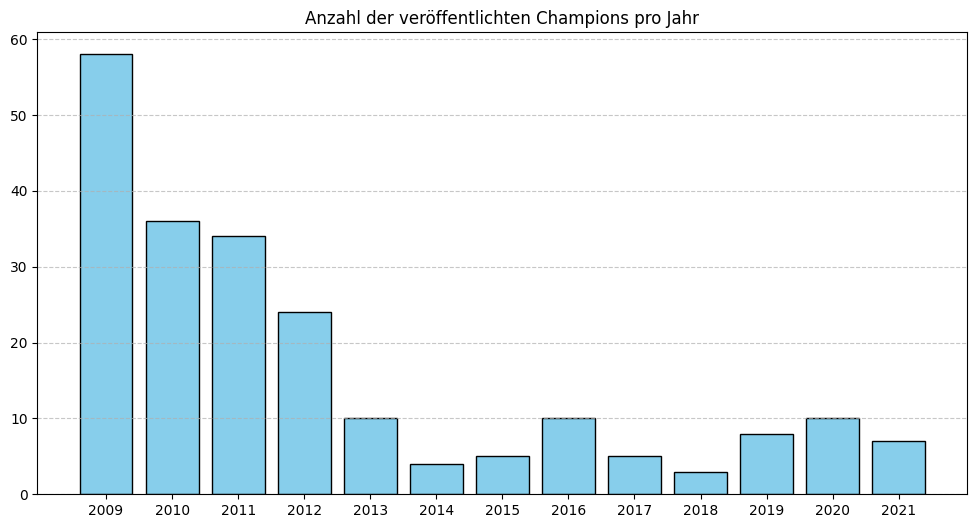

In [12]:
# Anzahl veröffentlichter Champions pro Jahr 
plt.figure(figsize=(12, 6))
plt.bar(release_counts.index, release_counts.values, color='skyblue', edgecolor='black')
plt.xlabel("")
plt.ylabel("")
plt.title("Anzahl der veröffentlichten Champions pro Jahr")
plt.xticks(release_counts.index) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Preprocessing: In numerische Werte umwandeln

In [13]:
# Umwandlung von Prozentangaben in numerische Werte
df["Win %"] = df["Win %"].str.replace('%', '').astype(float)
df["Role %"] = df["Role %"].str.replace('%', '').astype(float)
df["Pick %"] = df["Pick %"].str.replace('%', '').astype(float)
df["Ban %"] = df["Ban %"].str.replace('%', '').astype(float)


print(df["Pick %"].describe())



count    234.000000
mean       4.163077
std        4.089208
min        0.180000
25%        1.212500
50%        2.970000
75%        5.790000
max       24.550000
Name: Pick %, dtype: float64


In [14]:
scaler = StandardScaler()

df["Win %"] = scaler.fit_transform(df[["Win %"]])
df["Pick %"] = scaler.fit_transform(df[["Pick %"]])
df["Ban %"] = scaler.fit_transform(df[["Ban %"]])
df["Score"] = scaler.fit_transform(df[["Score"]])
df["KDA"] = scaler.fit_transform(df[["KDA"]])
df["release_year"] = scaler.fit_transform(df[["release_year"]])

### Betrachtung fehlender Werte

In [15]:
# Fehlende Werte
print(df.isnull().sum())

Name             0
Class            1
Role             0
Tier             0
Score            0
Trend            0
Win %            0
Role %           0
Pick %           0
Ban %            0
KDA              0
release_year    20
dtype: int64


In [16]:
# Alle Zeilen ausgeben, in denen das 'release_year' fehlt
missing_year_rows = df[df["release_year"].isnull()]
print(missing_year_rows)


             Name     Class     Role Tier     Score  Trend     Win %  Role %  \
14   Aurelion Sol      Mage      MID    B -0.474727  -2.74  0.447362   91.23   
25       Cho'Gath      Tank      TOP    A  0.170719   2.64  1.644586   72.56   
26       Cho'Gath      Tank      MID    C -0.742395  -4.65 -0.291224   17.42   
31      Dr. Mundo  Marksman      TOP    S  0.777232  -2.08  1.013214   91.81   
64      Jarvan IV      Tank   JUNGLE    A  0.302120   4.21  0.584358   93.41   
71         Kai'Sa  Marksman      ADC  God  1.555295  10.50 -0.344831   97.77   
84        Kha'Zix  Assassin   JUNGLE    S  0.626364  -2.33  0.066156   98.88   
90        Kog'Maw  Marksman      ADC    B -0.617686  -2.80  1.626717   89.17   
91        LeBlanc  Assassin      MID    A  0.558838  -1.18 -0.720081   94.88   
92        Lee Sin   Fighter   JUNGLE  God  2.551143   0.28 -0.958334   96.61   
107     Master Yi  Assassin   JUNGLE    S  0.890382  -3.49 -0.189967   93.04   
108  Miss Fortune  Marksman      ADC    

In [17]:
mean_year = round(df["release_year"].mean())  # Aufrunden, da Jahre ganzzahlig sind
df["release_year"].fillna(mean_year, inplace=True)


In [18]:
print(df.isnull().sum())

Name            0
Class           1
Role            0
Tier            0
Score           0
Trend           0
Win %           0
Role %          0
Pick %          0
Ban %           0
KDA             0
release_year    0
dtype: int64


In [19]:
# Die Zeile ausgeben, in welcher ein Wert für 'Class' fehlt
missing_names_rows = df[df["Class"].isnull()]  # Zeilen, in denen "Name" fehlt
print(missing_names_rows)

      Name Class Role Tier     Score  Trend     Win %  Role %    Pick %  \
95  Lillia   NaN  TOP    D -1.558176  -9.25 -0.511609   11.49 -0.922219   

       Ban %       KDA  release_year  
95 -0.624359 -0.902048      2.183163  


In [20]:
# Den Champion 'Lillia' anzeigen
df[df['Name'] == 'Lillia']

,Name,Class,Role,Tier,Score,Trend,Win %,Role %,Pick %,Ban %,KDA,release_year
94,Lillia,Fighter,JUNGLE,B,-0.452827,-1.69,-0.422264,85.39,-0.348754,-0.632140,0.791424,2.183163
95,Lillia,NaN,TOP,D,-1.558176,-9.25,-0.511609,11.49,-0.922219,-0.624359,-0.902048,2.183163


In [21]:
# Da ich weiss, dass Lillia Fighter ist, kann ich den Wert direkt einfügen
df.loc[df['Name'] == 'Lillia', 'Class'] = 'Fighter'

In [22]:
print(df.isnull().sum())

Name            0
Class           0
Role            0
Tier            0
Score           0
Trend           0
Win %           0
Role %          0
Pick %          0
Ban %           0
KDA             0
release_year    0
dtype: int64


### Weitere EDA-Visualisierungen

<Figure size 1200x600 with 0 Axes>

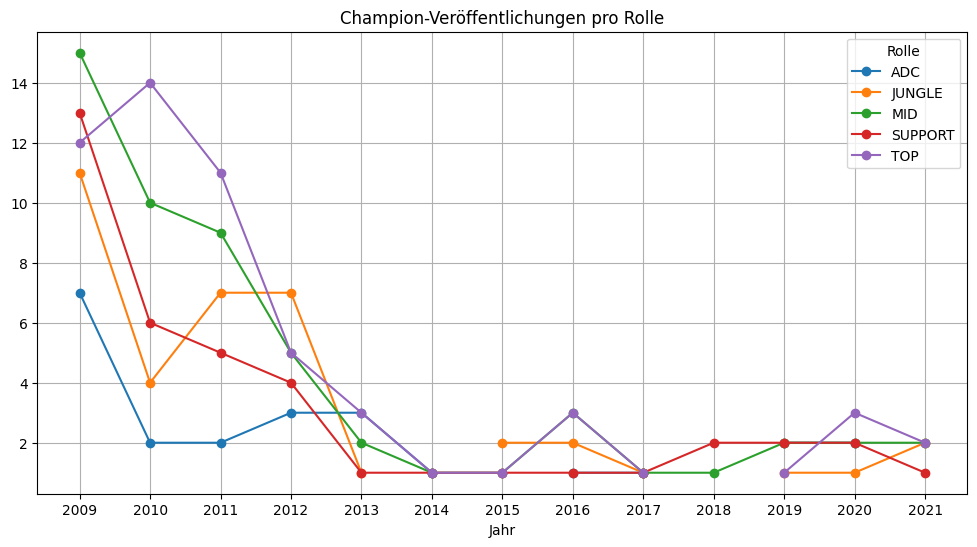

In [23]:
# Veröffentlichungen nach Rolle
plt.figure(figsize=(12, 6))
role_counts.plot(kind='line', marker='o', linestyle='-', figsize=(12, 6))
plt.xlabel("Jahr")
plt.ylabel("")
plt.title("Champion-Veröffentlichungen pro Rolle")
plt.xticks(release_counts.index)
plt.legend(title="Rolle")
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

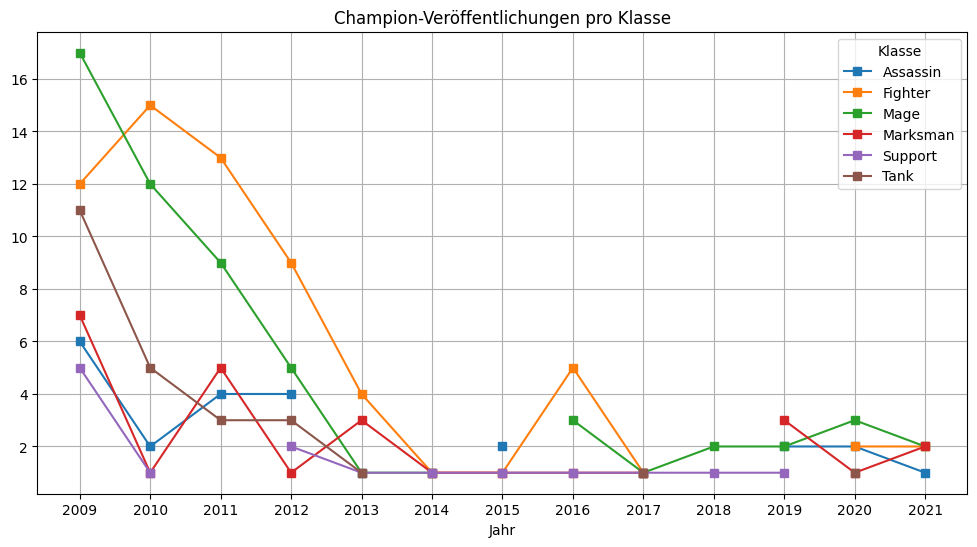

In [24]:
# Veröffentlichungen nach Klasse
plt.figure(figsize=(12, 6))
class_counts.plot(kind='line', marker='s', linestyle='-', figsize=(12, 6))
plt.xlabel("Jahr")
plt.ylabel("")
plt.title("Champion-Veröffentlichungen pro Klasse")
plt.xticks(release_counts.index)
plt.legend(title="Klasse")
plt.grid(True)
plt.show()

c:\Users\maxtr\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maxtr\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maxtr\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\maxtr\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning

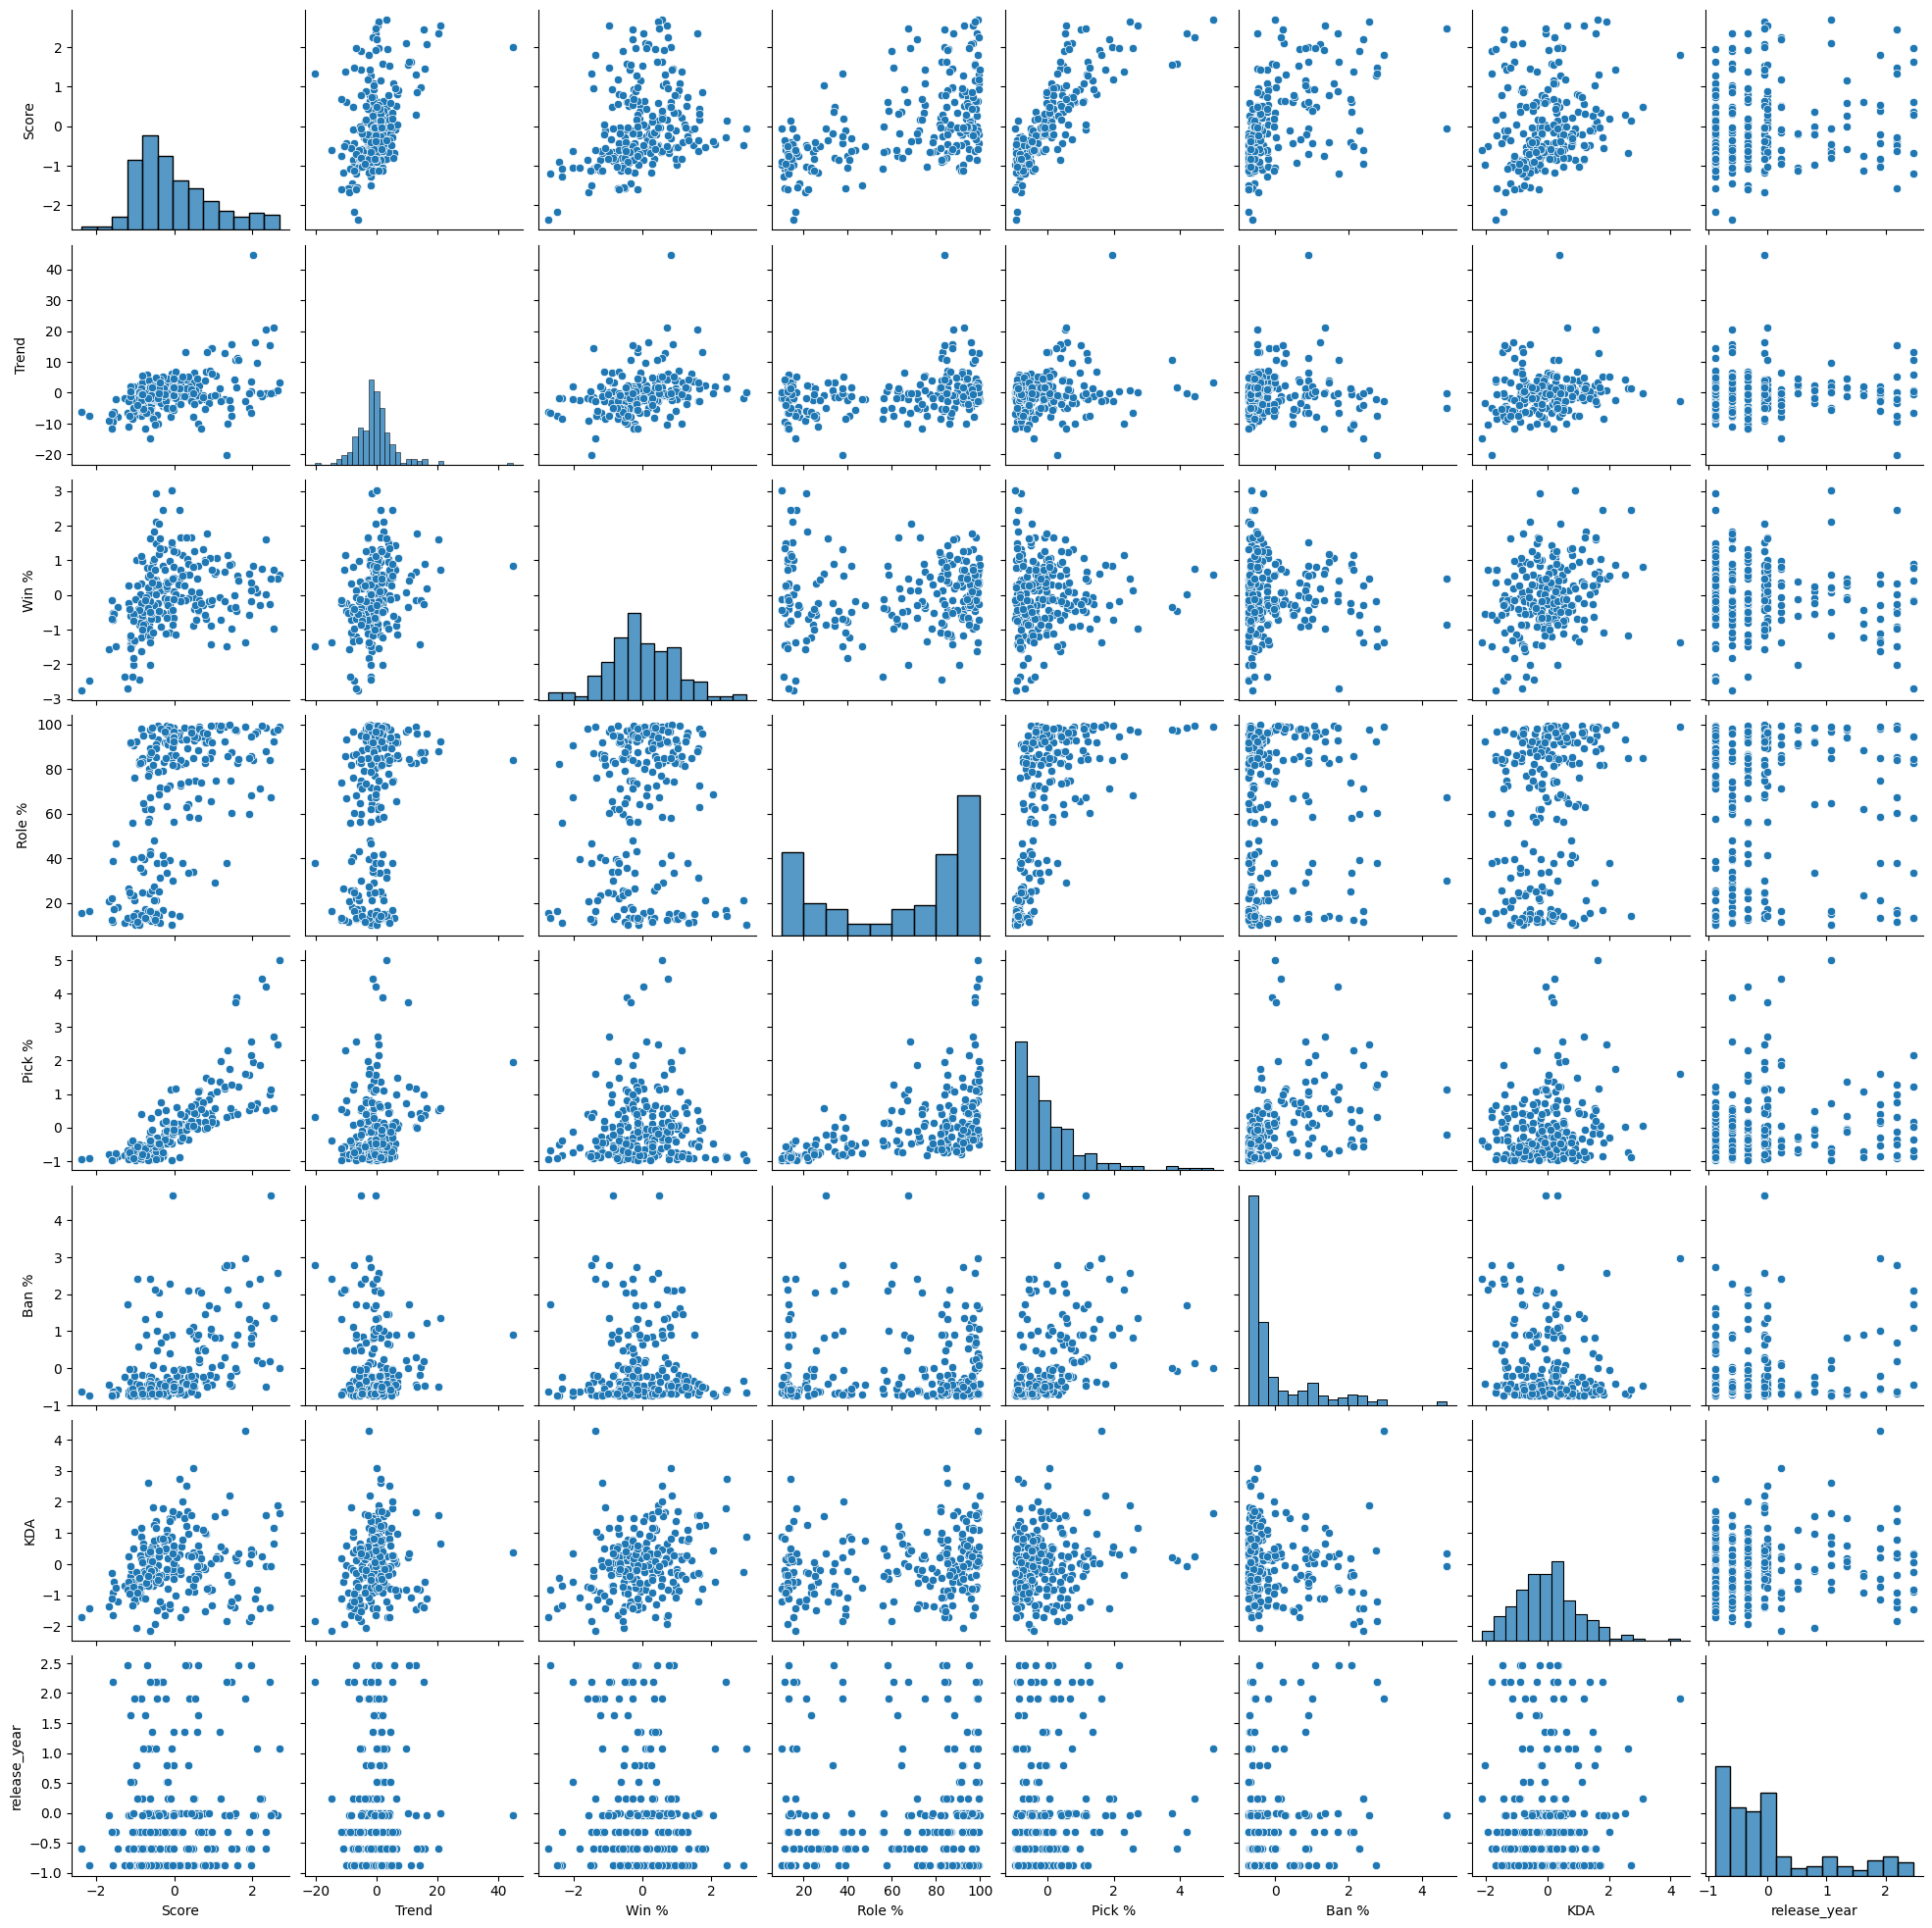

In [25]:
# Pairplot zur Visualisierung der Feature-Zusammenhänge
numerical_features = df.select_dtypes(include=[np.number]).columns
sns.pairplot(df[numerical_features])

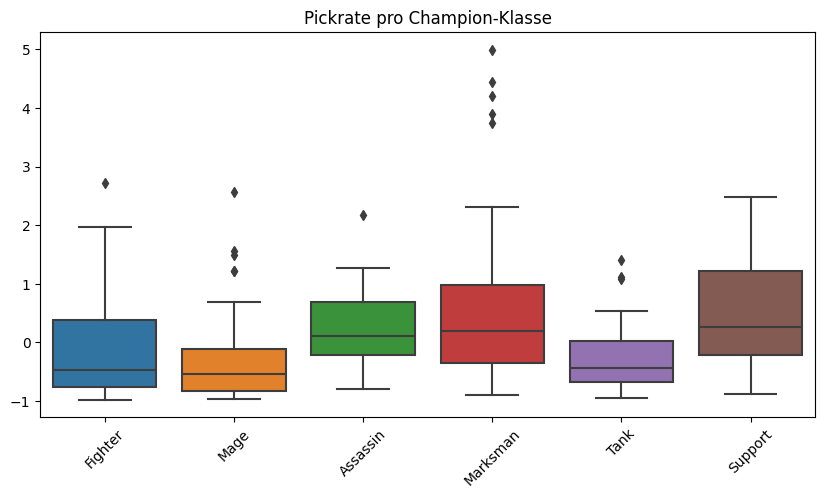

In [26]:
# Boxplot der Pickrate pro Klasse
plt.figure(figsize=(10, 5))
sns.boxplot(x='Class', y='Pick %', data=df)
plt.xlabel('')
plt.ylabel('')
plt.title('Pickrate pro Champion-Klasse')
plt.xticks(rotation=45)
plt.show()

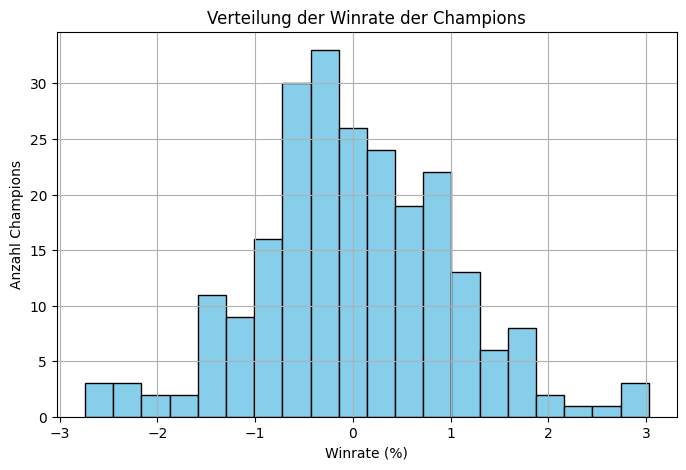

In [27]:
# Histogramm der Winrate
plt.figure(figsize=(8,5))
df['Win %'].hist(bins=20, color='skyblue', edgecolor='black')
plt.title('Verteilung der Winrate der Champions')
plt.xlabel('Winrate (%)')
plt.ylabel('Anzahl Champions')
plt.show()

### Ydata Profiling Report erstellen

In [28]:
# Bevor die Namensspalte entfernt wird, speichern wir den df in einer neuen Variable
df_name = df.copy()

In [29]:
df.head()

,Name,Class,Role,Tier,Score,Trend,Win %,Role %,Pick %,Ban %,KDA,release_year
0,Aatrox,Fighter,TOP,A,0.504696,6.52,-0.052971,94.62,0.065415,-0.492072,-0.877856,0.233027
1,Ahri,Mage,MID,A,0.198094,-0.24,-0.076796,93.47,0.111978,-0.620468,0.549500,-0.324155
2,Akali,Assassin,MID,S,0.933574,6.51,-0.874946,65.65,0.979527,0.915092,0.017266,-0.602746
3,Akali,Assassin,TOP,A,0.481580,3.34,-0.886858,34.06,0.018852,0.915092,-0.708508,-0.602746
4,Akshan,Marksman,MID,S,0.602030,0.65,0.834524,58.01,0.163443,2.086216,-0.248852,2.461753


In [30]:
df_name.head()

,Name,Class,Role,Tier,Score,Trend,Win %,Role %,Pick %,Ban %,KDA,release_year
0,Aatrox,Fighter,TOP,A,0.504696,6.52,-0.052971,94.62,0.065415,-0.492072,-0.877856,0.233027
1,Ahri,Mage,MID,A,0.198094,-0.24,-0.076796,93.47,0.111978,-0.620468,0.549500,-0.324155
2,Akali,Assassin,MID,S,0.933574,6.51,-0.874946,65.65,0.979527,0.915092,0.017266,-0.602746
3,Akali,Assassin,TOP,A,0.481580,3.34,-0.886858,34.06,0.018852,0.915092,-0.708508,-0.602746
4,Akshan,Marksman,MID,S,0.602030,0.65,0.834524,58.01,0.163443,2.086216,-0.248852,2.461753


In [31]:
# Für den ydata_profiling Report entfernen wir nicht float Datentypen wie 'Name'
df_profile_report = df.drop(['Name'], axis=1)

# Ydata Profiling Report erstellen
profile = ProfileReport(df, explorative=True)

# den Profile Report als HTML-Datei speichern
profile.to_file("ydata_profiling_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\maxtr\AppData\Local\Programs\Python\Python312\Lib\site-packages\ydata_profiling\model\correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: 'Fighter'')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Modellauswahl

Unser Modell soll vorhersagen, ob und wie Championeigenschaften wie deren Rolle zu einer Unterrepräsentation beitragen. Dazu werden mehrere Machnine Learning Modelle trainiert und anschließend verglichen. Die Modelle sind: Random Forest, Logistic Regression, Support Vector Machine und XGBoost.

### Feature Auswahl und Test-Train-Split

Zuerst wird die Zielvariable (Pick %) von den Features getrennt, und die Daten werden im Verhältnis 80:20 in Trainings- und Testsets aufgeteilt. Zudem wird die Spalte "Name" entfernt, da sie für das Modell nicht einfach in Kategorien oder numerische Werte umgewandelt werden kann.

In [32]:
# Die Spalte 'name' wird entfernt
df.drop(columns=["Name"], inplace=True, errors="ignore")

In [33]:
# Features und Zielvariable definieren
X = df.drop(columns=["Pick %"])  # Entferne Textspalten
y = df["Pick %"]

In [34]:
# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
X_train.head()

,Class,Role,Tier,Score,Trend,Win %,Role %,Ban %,KDA,release_year
117,Assassin,JUNGLE,B,-0.623161,-6.54,-1.196588,86.82,-0.335144,0.138228,-0.324155
155,Assassin,JUNGLE,S,0.788790,3.87,0.953651,82.67,1.470176,1.009157,-0.881336
148,Tank,TOP,D,-1.173098,-2.66,0.262715,13.18,-0.711253,0.234998,-0.045564
158,Fighter,JUNGLE,C,-0.856763,-5.10,-0.797513,82.59,-0.722925,0.283383,-0.324155
231,Support,SUPPORT,A,-0.031249,1.68,0.459275,81.95,-0.573779,1.686546,-0.881336


In [36]:
y_train.head()

117   -0.255627
155    0.445274
148   -0.941824
158   -0.655092
231   -0.191909
Name: Pick %, dtype: float64

### Preprocessing 2

Hier kombiniert eine Pipeline das Preprocessing.

In [37]:
# Identifikation numerischer und kategorischer Features
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

# Preprocessing Pipeline mit OrdinalEncoder (numerische Kodierung von Kategorien)
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_features)  
])


### Modelltestung

Nun werden die Modelle getestet, um zu sehen, welches Modell am besten performt.

In [38]:
# Modelle
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

In [39]:
# Training und Evaluation der Modelle
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    results[name] = {"R² Score": r2, "RMSE": rmse}
    print(f"{name}: R² = {r2:.4f}, RMSE = {rmse:.4f}\n")

Training Linear Regression...
Linear Regression: R² = 0.7753, RMSE = 0.4965

Training Random Forest...
Random Forest: R² = 0.9481, RMSE = 0.2386

Training XGBoost...
XGBoost: R² = 0.9640, RMSE = 0.1986

Training Neural Network...
Neural Network: R² = 0.9530, RMSE = 0.2270



In [40]:
# Bestes Modell basierend auf dem höchsten R² Score ermitteln
best_model_name = max(results, key=lambda k: results[k]["R² Score"])
print(f"Bestes Modell: {best_model_name}")

# Bestes Modell aus dem Dictionary holen
best_model = models[best_model_name]


Bestes Modell: XGBoost


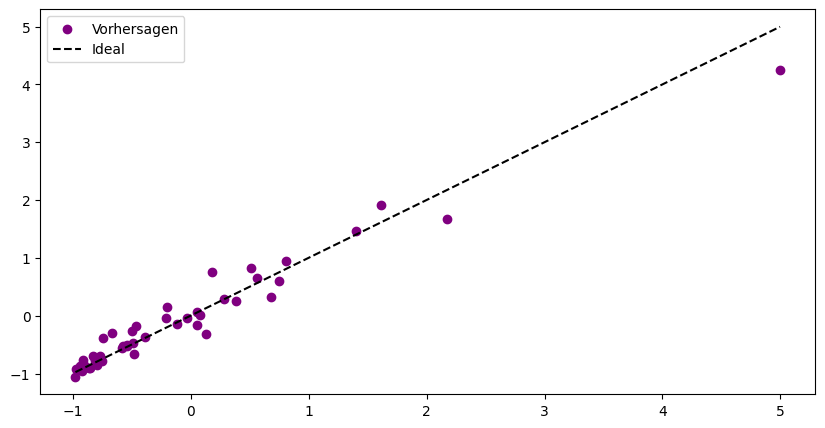

In [41]:
# Visualisierung der Vorhersage
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, color='purple', label="Vorhersagen")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='black', label="Ideal")
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.show()


## Training des Modells


Es wird KEIN Hyperparameter Tuning  mittels GridSearchCV durchgeführt, da die Genauigkeit des Modells bereits äußerst hoch ist und sich so nicht wirklich verbessern würde.


In [42]:
# Training von XGBoost mit Standard-Parametern
xgb_model = XGBRegressor(random_state=42)
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", xgb_model)
])

pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Score', 'Trend', 'Win %',
                                                   'Role %', 'Ban %', 'KDA',
                                                   'release_year']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Class', 'Role', 'Tier'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsampl...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [43]:
# Modell speichern
with open("lol_pickrate_model.pkl", "wb") as file:
    pickle.dump(pipeline, file) 

## Championgenerierung / Ergebnisinterpretation

Jetzt wollen wir das beste Modell anwenden, um zu testen, ob es genau ist
Daher nehmen wir die Werte eine Champions der Reihe 1 und testen, ob das Modell 
die Pickrate korrekt vorhersagt
Dazu müssen wir die Werte nicht aus den Trainingsdaten nemhen, sondern aus den ursprünglichen Daten

In [44]:
# Wir bedienen uns der vor langer Zeit erstellten "Backup" - Variable df_name,
# um die Spalte 'Name' wieder hinzuzufügen

df_name.head()

,Name,Class,Role,Tier,Score,Trend,Win %,Role %,Pick %,Ban %,KDA,release_year
0,Aatrox,Fighter,TOP,A,0.504696,6.52,-0.052971,94.62,0.065415,-0.492072,-0.877856,0.233027
1,Ahri,Mage,MID,A,0.198094,-0.24,-0.076796,93.47,0.111978,-0.620468,0.549500,-0.324155
2,Akali,Assassin,MID,S,0.933574,6.51,-0.874946,65.65,0.979527,0.915092,0.017266,-0.602746
3,Akali,Assassin,TOP,A,0.481580,3.34,-0.886858,34.06,0.018852,0.915092,-0.708508,-0.602746
4,Akshan,Marksman,MID,S,0.602030,0.65,0.834524,58.01,0.163443,2.086216,-0.248852,2.461753


In [45]:
# die echten Werte des Champions "Aatrox' anzeigen
champion = df_name[df_name['Name'] == 'Aatrox'].iloc[0].to_dict()
champion

{'Name': 'Aatrox',
 'Class': 'Fighter',
 'Role': 'TOP',
 'Tier': 'A',
 'Score': 0.5046964461174769,
 'Trend': 6.52,
 'Win %': -0.05297070278364713,
 'Role %': 94.62,
 'Pick %': 0.06541493586907654,
 'Ban %': -0.4920724946414896,
 'KDA': -0.8778556315079814,
 'release_year': 0.23302689454363165}

In [46]:
# Pickrate vorhersagen
with open("lol_pickrate_model.pkl", "rb") as file:
    model = pickle.load(file)

In [47]:
# Werte des Champions in ein DataFrame umwandeln
champion_df = pd.DataFrame([champion])

# Namensspalte rausnehmen
champion_df = champion_df.drop(columns=["Name"], errors="ignore")
                               
# Pickrate vorhersagen
pickrate = model.predict(champion_df)[0]
print(f"Vorhergesagte Pickrate für Aatrox: {pickrate:.4f}")


Vorhergesagte Pickrate für Aatrox: 0.0642


In [48]:
# Werte des Champions "Xerath' betrachten
champion = df_name[df_name['Name'] == 'Xerath'].iloc[0].to_dict()
champion

{'Name': 'Xerath',
 'Class': 'Mage',
 'Role': 'MID',
 'Tier': 'A',
 'Score': 0.20052775750165083,
 'Trend': 5.16,
 'Win %': 0.5664887027630932,
 'Role %': 38.11,
 'Pick %': -0.29238779692489225,
 'Ban %': -0.03814846288836109,
 'KDA': 2.025240132565047,
 'release_year': -0.32415473039871}

In [49]:
champion = df_name[df_name['Name'] == 'Xerath'].iloc[0].to_dict()
champion_df = pd.DataFrame([champion])
champion_df = champion_df.drop(columns=["Name"], errors="ignore")
pickrate = pipeline.predict(champion_df)[0]
print(f"Vorhergesagte Pickrate für Xerath: {pickrate:.4f}")

Vorhergesagte Pickrate für Xerath: -0.2922


Die Pickrates wurden super vorhergesagt! :D

In [50]:
# Champion mit niedrigster Pickrate als Vergleich anzeigen
champion_underrep = df_name.loc[df_name["Pick %"].idxmin()]
print("Champion mit den am niedrigsten Pickrate:")
print(champion_underrep)

Champion mit den am niedrigsten Pickrate:
Name             Skarner
Class            Fighter
Role                 TOP
Tier                   D
Score          -1.585551
Trend              -6.83
Win %          -0.690299
Role %             22.21
Pick %         -0.976134
Ban %          -0.734598
KDA            -0.273044
release_year   -0.324155
Name: 164, dtype: object


In [51]:
# Modell laden
with open("lol_pickrate_model.pkl", "rb") as file:
    model = pickle.load(file)

In [52]:
# Definiere kategoriale Features
categorical_features = ['Class', 'Role', 'Tier']

# Extrahieren der einzigartigen Werte für die Spalten
cat_values = {col: df[col].unique() for col in categorical_features}

In [53]:
# Auswählen der kontinuierlichen Features, außabseits 'Name' und 'Pick %' und den kategorialen Spalten
non_cat_features = [col for col in df.columns if col not in ['Name', 'Pick %'] + categorical_features]

In [54]:
# Setzen der continuous Features 
cont_values = {col: df[col].min() for col in non_cat_features if pd.api.types.is_numeric_dtype(df[col])}

# Initialisieren der Variablen, um den Champion mit der niedrigsten Pickrate zu speichern
min_pred = float('inf')
best_candidate = None


In [55]:
# Iterieren durch alle Kombinationen der kategorialen Werte
for comb in itertools.product(*[cat_values[col] for col in categorical_features]):
    candidate = cont_values.copy()
    for i, col in enumerate(categorical_features):
        candidate[col] = comb[i]
    candidate_df = pd.DataFrame([candidate])
    pred = model.predict(candidate_df)[0]
    if pred < min_pred:
        min_pred = pred
        best_candidate = candidate

print("Theoretische Champion-Komposition")
print(best_candidate)
print("Vorhergesagte Pickrate: {:.4f}".format(min_pred))

Theoretische Champion-Komposition
{'Score': -2.3678726491703848, 'Trend': -20.17, 'Win %': -2.7392802402988394, 'Role %': 10.09, 'Ban %': -0.734597620178161, 'KDA': -2.135863795939627, 'release_year': -0.8813363553410517, 'Class': 'Fighter', 'Role': 'MID', 'Tier': 'A'}
Vorhergesagte Pickrate: -0.8147


## Ergebnisinterpretation

Die Analyse zeigt, dass die Rolle "Mid", die Klasse "Kämpfer" (Class Fighter), eine sehr negative KDA (Kill-Death-Ratio) und eine sehr geringe Banrate nach dem Modell unterrepräsentierte Champions ausmacht. Das macht auf der einen Seite Sinn, wenn man bedenkt, dass weniger viable (schlechtere) Charaktere auch eine geringere Wahrscheinlichkeit haben ausgewählt zu werden. Darauf weist auch die neidrige KDA und Win % (Beispielsweise der Score mit ca. -2,136 ist weit unter dem Durchschnitt). Auch die Klasse und Rolle lassen sich logisch nachvollziehen, beispielsweise wurden Champions der Klasse "Fighter", in den letzten Jahren oft gar nicht oder selten pro Jahr veröffentlicht. Weiters wird auf diese Thematik in der schriftlichen Arbeit genauer eingegangen.

Limitationen:
Unser theoretischer Champion-Blueprint, der auf den minimalen Werten der kontinuierlichen Merkmale basiert, weist eine äußerst niedrige, jedoch weniger extreme Pickrate auf als der reale Champion "Skarner". Dies liegt darin begründet, dass bei der Berechnung nicht alle Faktoren für eine Charakterwahl berücksichtigt werden. So ist es beispielsweise in diesem Fall so, dass "Skarner" ein Charakter ist, welcher fast ausschließlich in der Rolle "Jungle" gespielt wird. So wird dessen Auswahlrate auf einer anderen Rolle stark durch dessen starke Präsenz in dieser Rolle beeinflusst. Auch Faktoren wie Beliebtheit des Charakters in der Spielerschaft aufgrund Eigenschaften wie dessen Aussehen oder Spielspaß kann nicht berücksichtigt werden. Zudem können Regularisierungs- und Transformationseffekte im Modell zu einer stärkeren Betonung extremer Ausprägungen führen, die in unserem simplen Ansatz nicht abgebildet werden. Insgesamt verdeutlicht das Ergebnis, dass der extrapolative Ansatz die tatsächlichen Ausreißer in den realen Daten nicht vollständig reproduzieren kann, jedoch einen datenbasierten Ansatz liefern kann, welche Eigenschaften von Charakteren tendentiell zu einer Unterrepresäntation führen.


In [56]:
# Die durchschnittliche Pickrate von allen verschiedenen Tiers berechnen
tier_pickrate = df_name.groupby('Tier')['Pick %'].mean().sort_values()
tier_pickrate

Tier
D     -0.801624
C     -0.716360
B     -0.459617
A     -0.017909
S      0.790967
God    1.982291
Name: Pick %, dtype: float64

In [57]:
# Pickrates von allen Tier A Champions vom df anzeigen
tier_a_champions = df_name[df_name['Tier'] == 'A'] 
tier_a_champions[['Name', 'Pick %']].sort_values(by='Pick %', ascending=True).head(15)

,Name,Pick %
87,Kled,-0.973683
86,Kled,-0.973683
230,Zilean,-0.883007
11,Annie,-0.488444
30,Diana,-0.488444
41,Galio,-0.461486
133,Rammus,-0.429627
25,Cho'Gath,-0.385515
5,Akshan,-0.356106
96,Lissandra,-0.353655


Und tatsächlich: Die Spielstärke "Tier A" erzwingt keine überdurchschnittliche Pickrate. Das Modell scheint hier keinen fatalen Fehler gemacht zu haben. Ein höheres Tier korreliert zwar direkt mit einer durchschnittlich höheren Pickrate, aber Es gibt sehr wohl Champions wie Kled, die zwar Tier A sind, allerdings zu den am wenigsten ausgewählten Charakteren gehören.